In [20]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.metrics import classification_report_imbalanced
from imblearn import pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [21]:
# Load the data
df = pd.read_csv("D:/project/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [22]:
# Print the number of rows and features of the dataset
df.shape

(284807, 31)

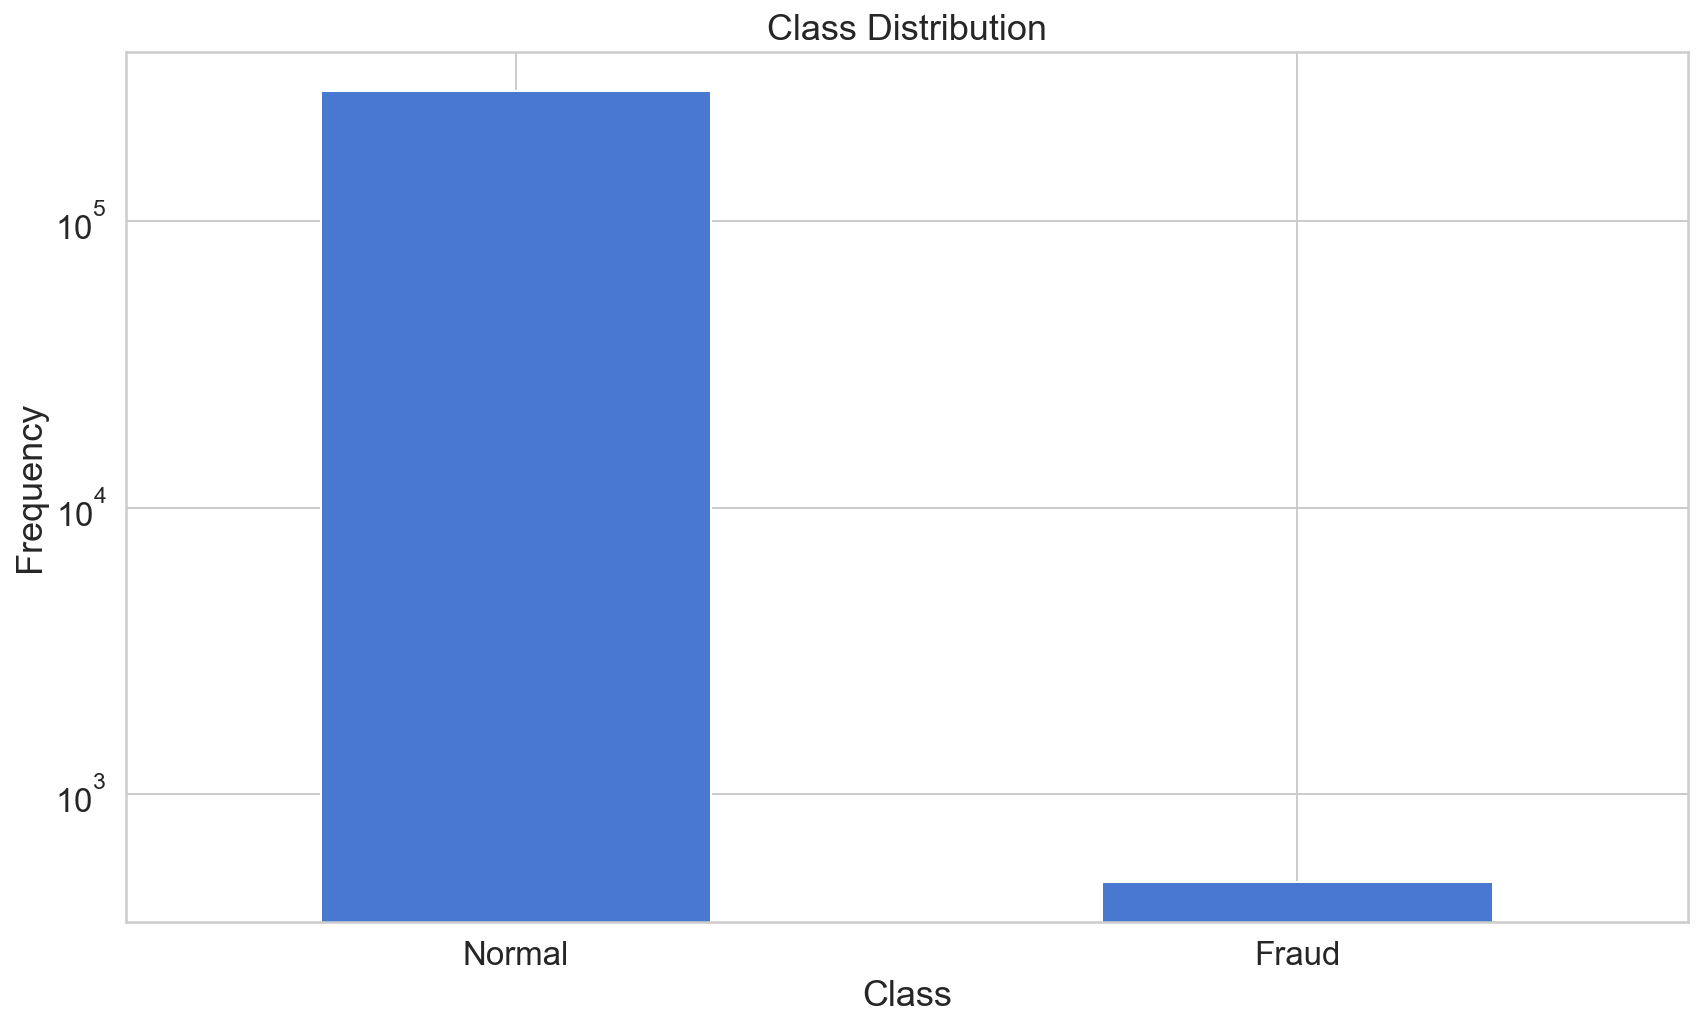

In [4]:
# Plot the distribution of each class in a log scale
number_of_classes = pd.value_counts(df['Class'], sort = True)
number_of_classes.plot(kind = 'bar', rot=0)
plt.title("Class Distribution")
plt.xticks(range(len(number_of_classes)), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");
plt.yscale('log')

In [23]:
normal = df[df.Class == 0]
fraud = df[df.Class == 1]
print("Normal: {}, Frauds: {}".format(normal.shape[0], fraud.shape[0]))

Normal: 284315, Frauds: 492


In [24]:
fraud['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [25]:
normal['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

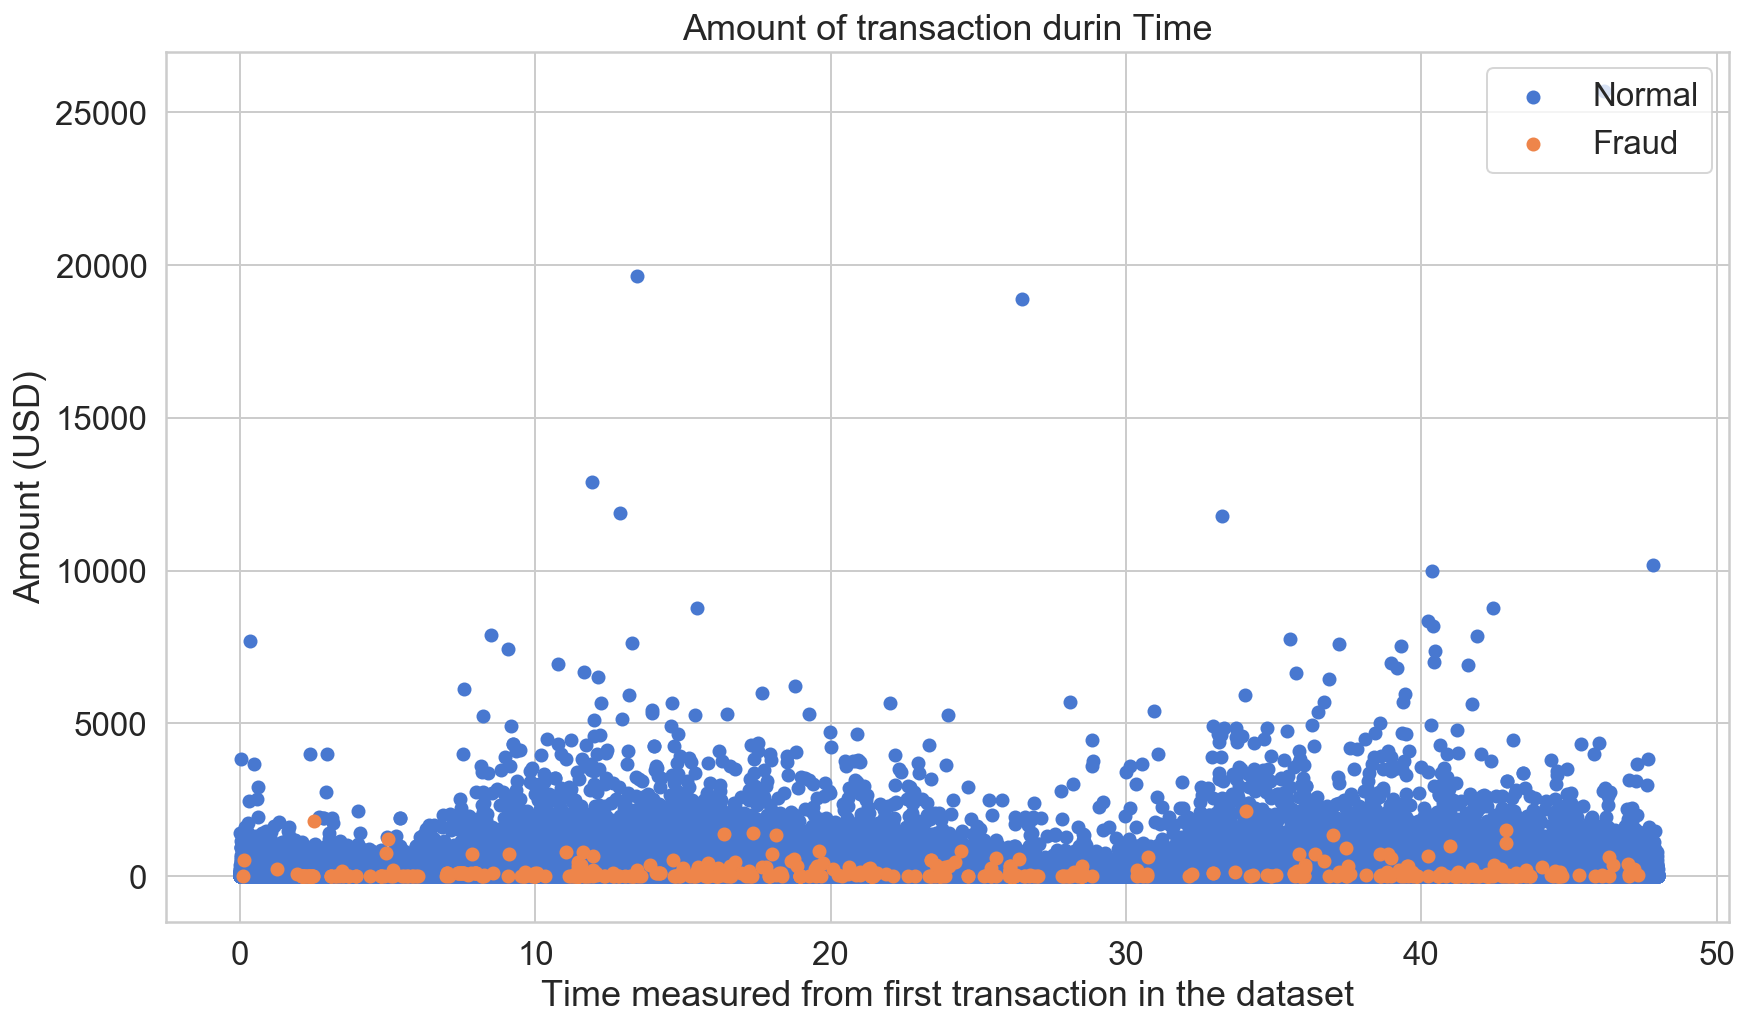

In [26]:
# Plot the the amount of transactions w.r.t. time 
plt.scatter((normal['Time']/(3600)), normal['Amount'], alpha=1, label='Normal')
plt.scatter((fraud['Time']/(3600)), fraud['Amount'], alpha=1, label='Fraud')
plt.title("Amount of transaction durin Time")
plt.xlabel("Time measured from first transaction in the dataset")
plt.ylabel('Amount (USD)')
plt.legend(loc='upper right')
plt.show()

In [27]:
# We plot the shape of the 'cleaned' dataset
df['normAmount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
data = df.drop(['Time', 'Amount'], axis=1) 
data.shape


(284807, 30)

In [28]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [29]:
X = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']

In [30]:
# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = RANDOM_SEED)

# We use a subset of training for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=RANDOM_SEED)
X_train.shape

(179427, 29)

In [31]:
#Apply SMOTE to create synthetic observations from minority class
sm = SMOTE(random_state=RANDOM_SEED)
X_sampled,y_sampled = sm.fit_sample(X_train,y_train.values.ravel())

Percentage of fraud counts in original dataset:0.1727485630620034%
Percentage of fraud counts in the new data:50.0%
Normal: 179108, Frauds: 179108


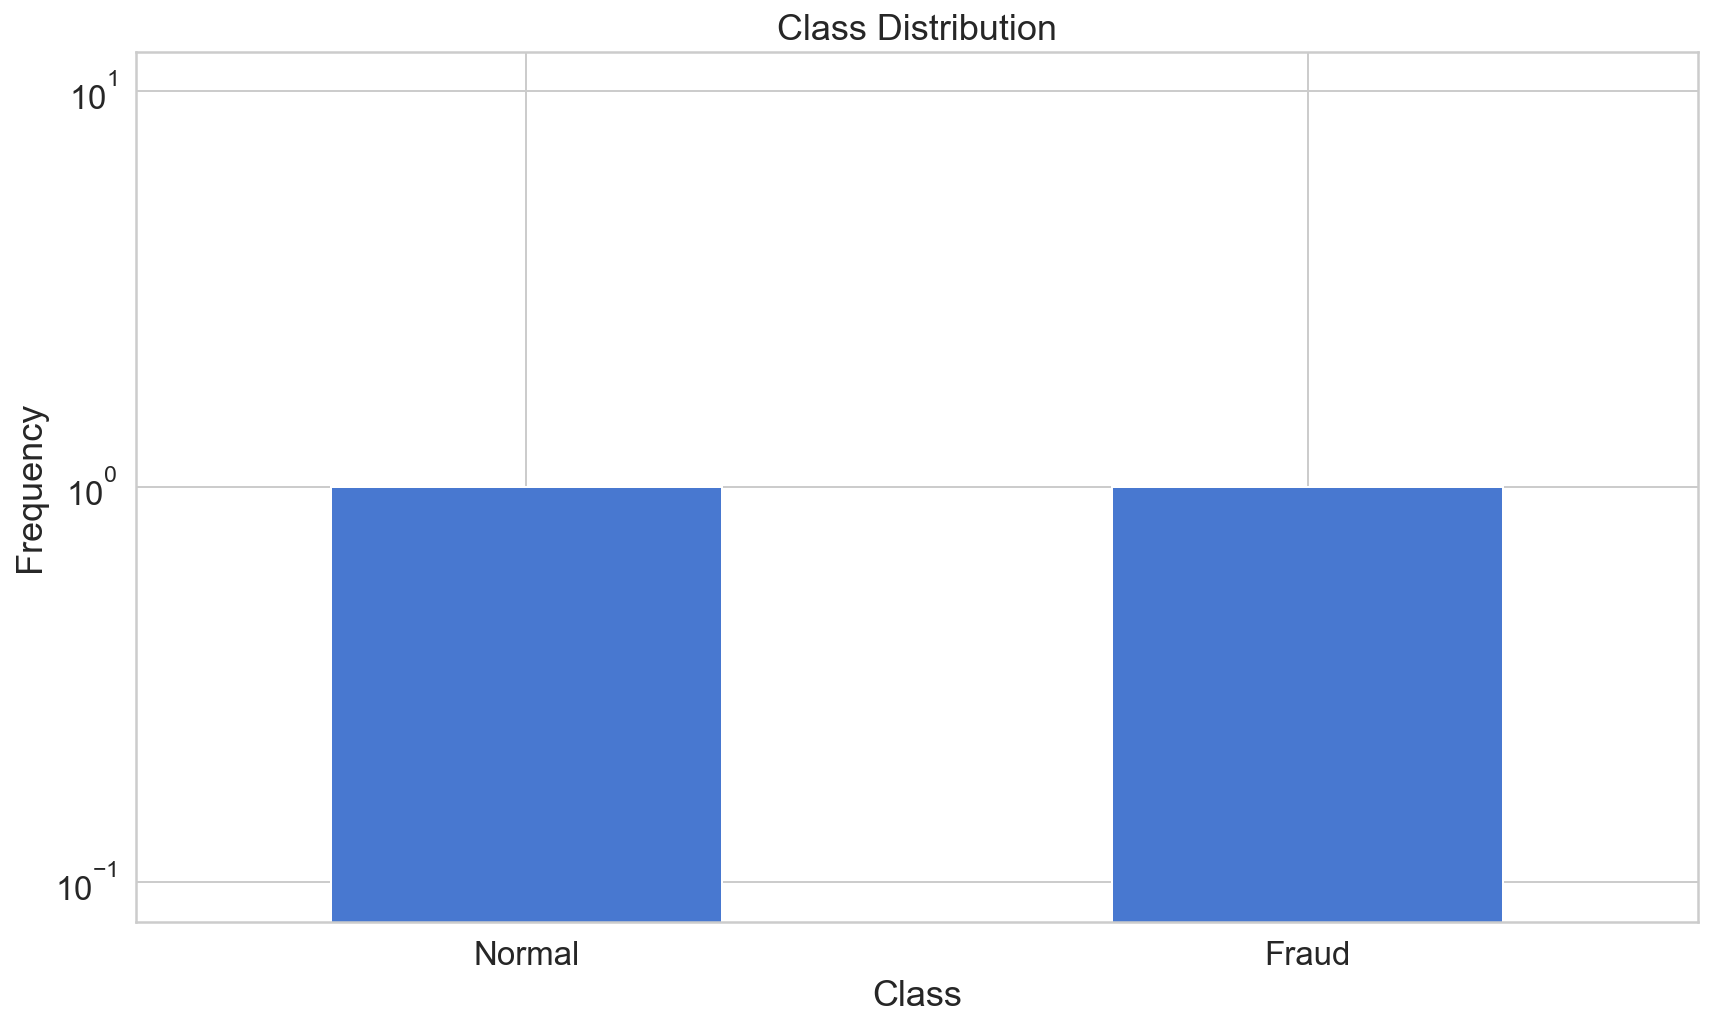

In [32]:
#Percentage of fraudlent records in original data
Source_data_no_fraud_count = len(data[data.Class==0])
Source_data_fraud_count = len(data[data.Class==1])
print('Percentage of fraud counts in original dataset:{}%'.format((Source_data_fraud_count*100)/(Source_data_no_fraud_count+Source_data_fraud_count)))

#Percentage of fraudlent records in sampled data
Sampled_data_no_fraud_count = len(y_sampled[y_sampled==0])
Sampled_data_fraud_count = len(y_sampled[y_sampled==1])
print('Percentage of fraud counts in the new data:{}%'.format((Sampled_data_fraud_count*100)/(Sampled_data_no_fraud_count+Sampled_data_fraud_count)))
X_sampled.shape

#Normal vs Fraud Count
print("Normal: {}, Frauds: {}".format(Sampled_data_no_fraud_count, Sampled_data_fraud_count))

# Plot the distribution of each class in a log scale
new_number_of_classes = pd.value_counts(['Sampled_data_no_fraud_count','Sampled_data_fraud_count'], sort = True)
new_number_of_classes.plot(kind = 'bar', rot=0)
plt.title("Class Distribution")
plt.xticks(range(len(new_number_of_classes)), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");
plt.yscale('log')

In [34]:

# Train the model
classifier = RandomForestClassifier(random_state=RANDOM_SEED)
rf_model = classifier.fit(X_sampled, y_sampled)

In [ ]:
# Print the results for validation and test sets
print('Validation Results')
print(rf_model.score(X_val, y_val))
print(recall_score(y_val, rf_model.predict(X_val)))
print('\nTest Results')
print(rf_model.score(X_test, y_test))
print(recall_score(y_test, rf_model.predict(X_test)))

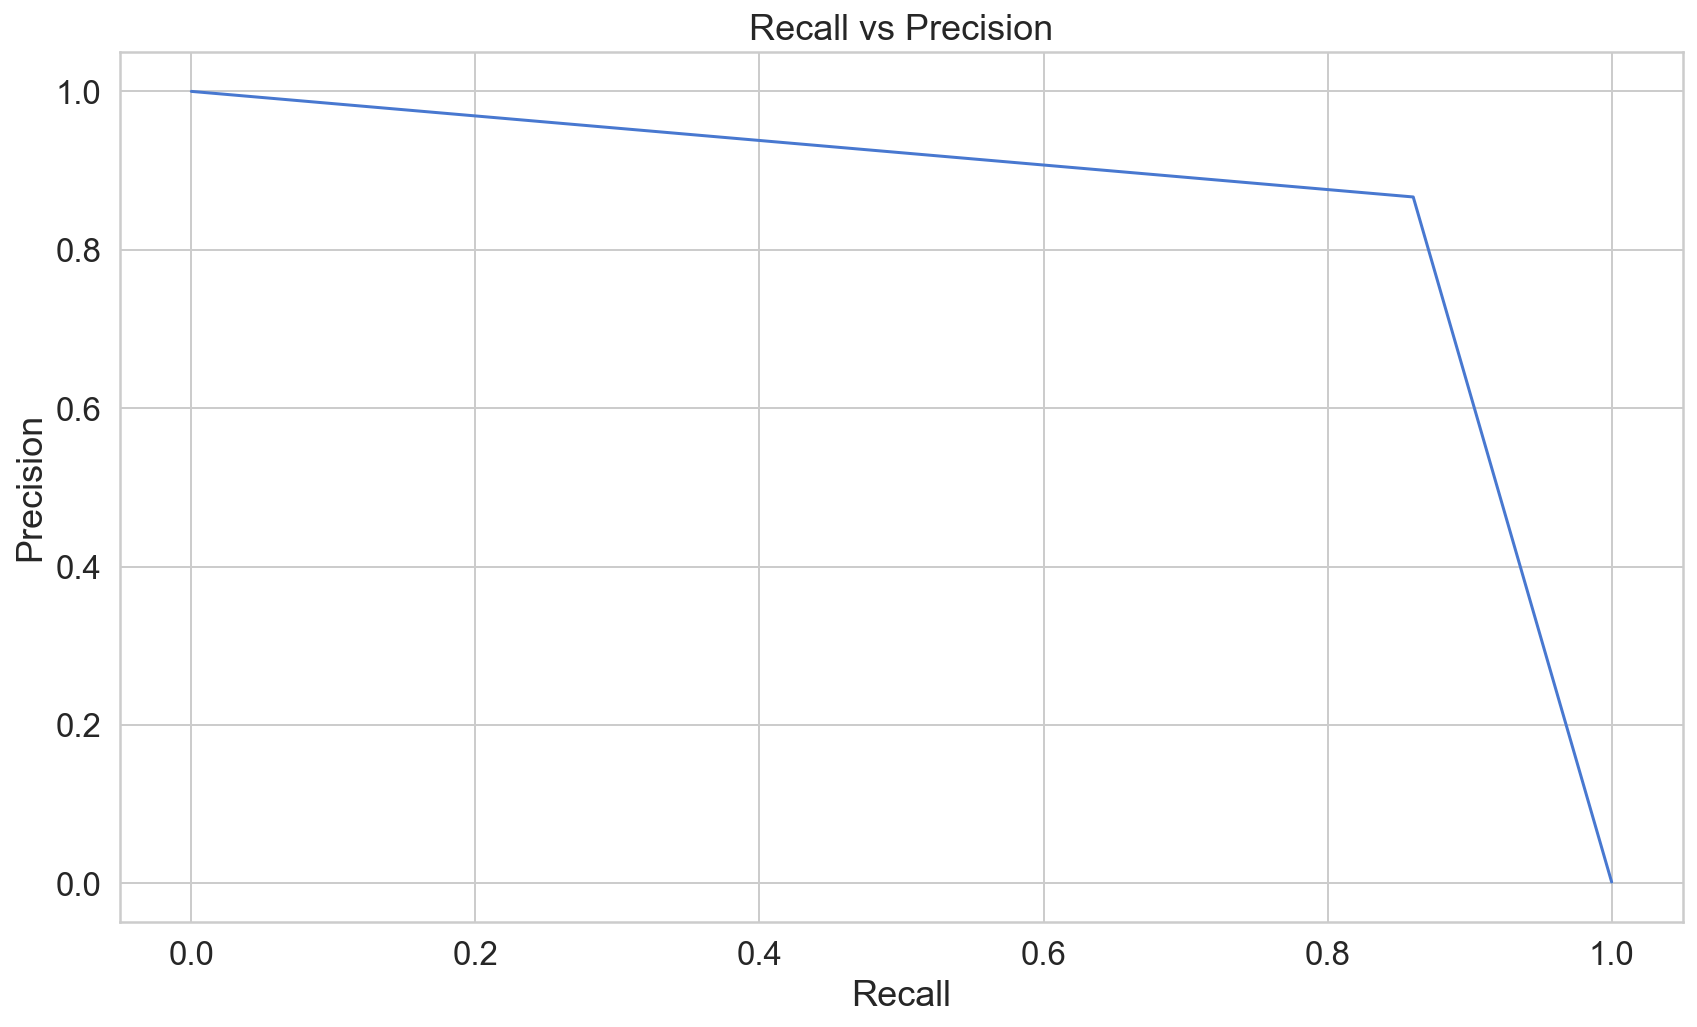

In [43]:
# Plot precision-recall curve
precision, recall, th = precision_recall_curve(y_test, rf_model.predict(X_test))
plt.figure(figsize=(14,8))
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [44]:
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, cohen_kappa_score, accuracy_score, average_precision_score, roc_auc_score

In [45]:
def classification_eval(estimator, X_test, y_test):
    """
    Print several metrics of classification performance of an estimator, given features X_test and true labels y_test.
    
    Input: estimator or GridSearchCV instance, X_test, y_test
    Returns: text printout of metrics
    """
    y_pred = estimator.predict(X_test)
    
    # Number of decimal places based on number of samples
    dec = np.int64(np.ceil(np.log10(len(y_test))))
    
    print('CONFUSION MATRIX')
    print(confusion_matrix(y_test, y_pred), '\n')
    
    print('CLASSIFICATION REPORT')
    print(classification_report(y_test, y_pred, digits=dec))
    
    print('SCALAR METRICS')
    format_str = '%%13s = %%.%if' % dec
    print(format_str % ('MCC', matthews_corrcoef(y_test, y_pred)))
    #if y_test.nunique() <= 2:
        # Additional metrics for binary classification
        #try:
    y_score = estimator.predict_proba(X_test)[:,1]
        #except:
           # y_score = estimator.decision_function(X_test)
    print(format_str % ('AUPRC', average_precision_score(y_test, y_score)))
    print(format_str % ('AUROC', roc_auc_score(y_test, y_score)))
    print(format_str % ("Cohen's kappa", cohen_kappa_score(y_test, y_pred)))
    print(format_str % ('Accuracy', accuracy_score(y_test, y_pred)))

In [46]:
classification_eval(rf_model, X_test, y_test)

CONFUSION MATRIX
[[85289    18]
 [   19   117]] 

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0    0.99978   0.99979   0.99978     85307
           1    0.86667   0.86029   0.86347       136

    accuracy                        0.99957     85443
   macro avg    0.93322   0.93004   0.93163     85443
weighted avg    0.99957   0.99957   0.99957     85443

SCALAR METRICS
          MCC = 0.86326
        AUPRC = 0.88488
        AUROC = 0.97936
Cohen's kappa = 0.86325
     Accuracy = 0.99957
